In [23]:
from src.database import DatabaseXRD,snip,Phase,MixPhase
from src.gaussnewton import GaussNewton
from numpy import newaxis,save,loadtxt,diag,histogram,arange,linspace,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import imshow,plot,show,vlines,xlim,ylim,figure,semilogx,scatter,xlabel,ylabel,subplots,gca,savefig

from glob import glob

from scipy import signal
from numpy import fft,pad,concatenate,stack,sqrt

from src.spectra import Spectra
from src.xrd_data import DataXRD

from scipy.ndimage.filters import uniform_filter1d

In [2]:
database = DatabaseXRD().read_cifs('Database/')

calcite = database['Calcite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][2]
spinel = database['Spinel'][0]
barite = database['Barite'][0]
lazurite = database['Lazurite'][0]

In [3]:
xrd_data = DataXRD().load_h5('/home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M491/ProfiloXRD/data.h5')

Loading: /home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M491/ProfiloXRD/data.h5
Load inverted
Load convoluted


In [4]:
def fce_calibration(x,a,beta,s):
    return (arctan((x+a)/s)) * 180 / pi + beta

In [5]:
files = glob('Profilo/Cinabar_bottom/roi*.dat')
phase = MixPhase([cinnabar,hydrocerussite])

xrd_gauss_newton = []
xrd_spectra = []

for file in files:
    
    spectra = Spectra(file)
    spectra.calibrate_from_file('/home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M0795/CappelloGialloXRD/calibration.ini')
    spectra.convolve(4).raw_snip(m=32)
    
    xrd_gauss_newton += [GaussNewton(phase,spectra)]

(0.0, 1280.0)

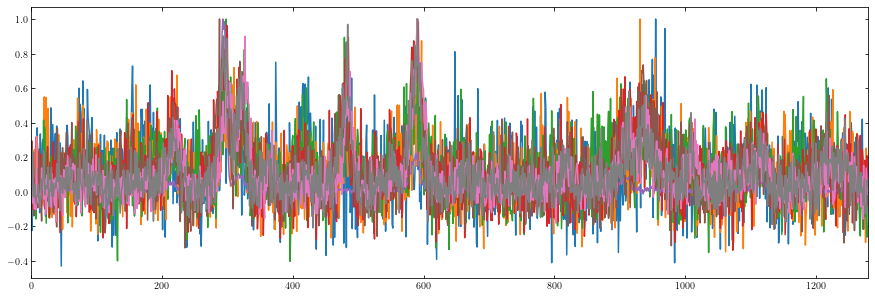

In [6]:
figure(figsize=(15,5))
for g in xrd_gauss_newton:
    plot(g.spectra.intensity)
xlim(0,1280)

[-1187.2963314751537, 51.0, 1956.0861974861386] 58.81430698863842
[-1186.1528776398402, 51.0, 1949.7460138604572] 39.79849615578813
[-1180.2440221196264, 51.00000000000002, 1941.9569631377776] 38.207368657426976
[-1185.41972937217, 50.99999999999998, 1958.1614578096096] 26.45022048375912
[-1181.634755863395, 50.99999999999997, 1950.0992469753517] 1.5628215772518868
[-1187.0515940286296, 50.999999999999964, 1964.9848795721173] 23.213206108016966
[-1189.491574669184, 51.00000000000001, 1955.8279066619652] 10.399596479513688
[-1185.320716086108, 51.000000000000014, 1956.7210420266179] 13.629051900733828


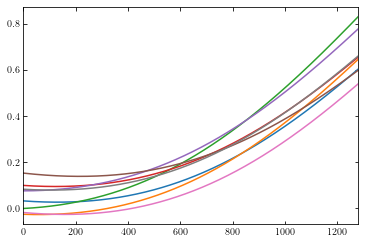

In [8]:
x = arange(1280)
    
for g in xrd_gauss_newton:
    
    g.spectra.opt = [-1186.106076632754, 51., 1954.6937605682037]
        
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()
    for _ in range(2):
        g.calibration_nobeta(alpha=0.5)
        g.opt = g.spectra.opt.copy()

    print(g.spectra.opt,g.dz)
    
    opt = g.spectra.opt
    opt_file = g.spectra.opt_file
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)

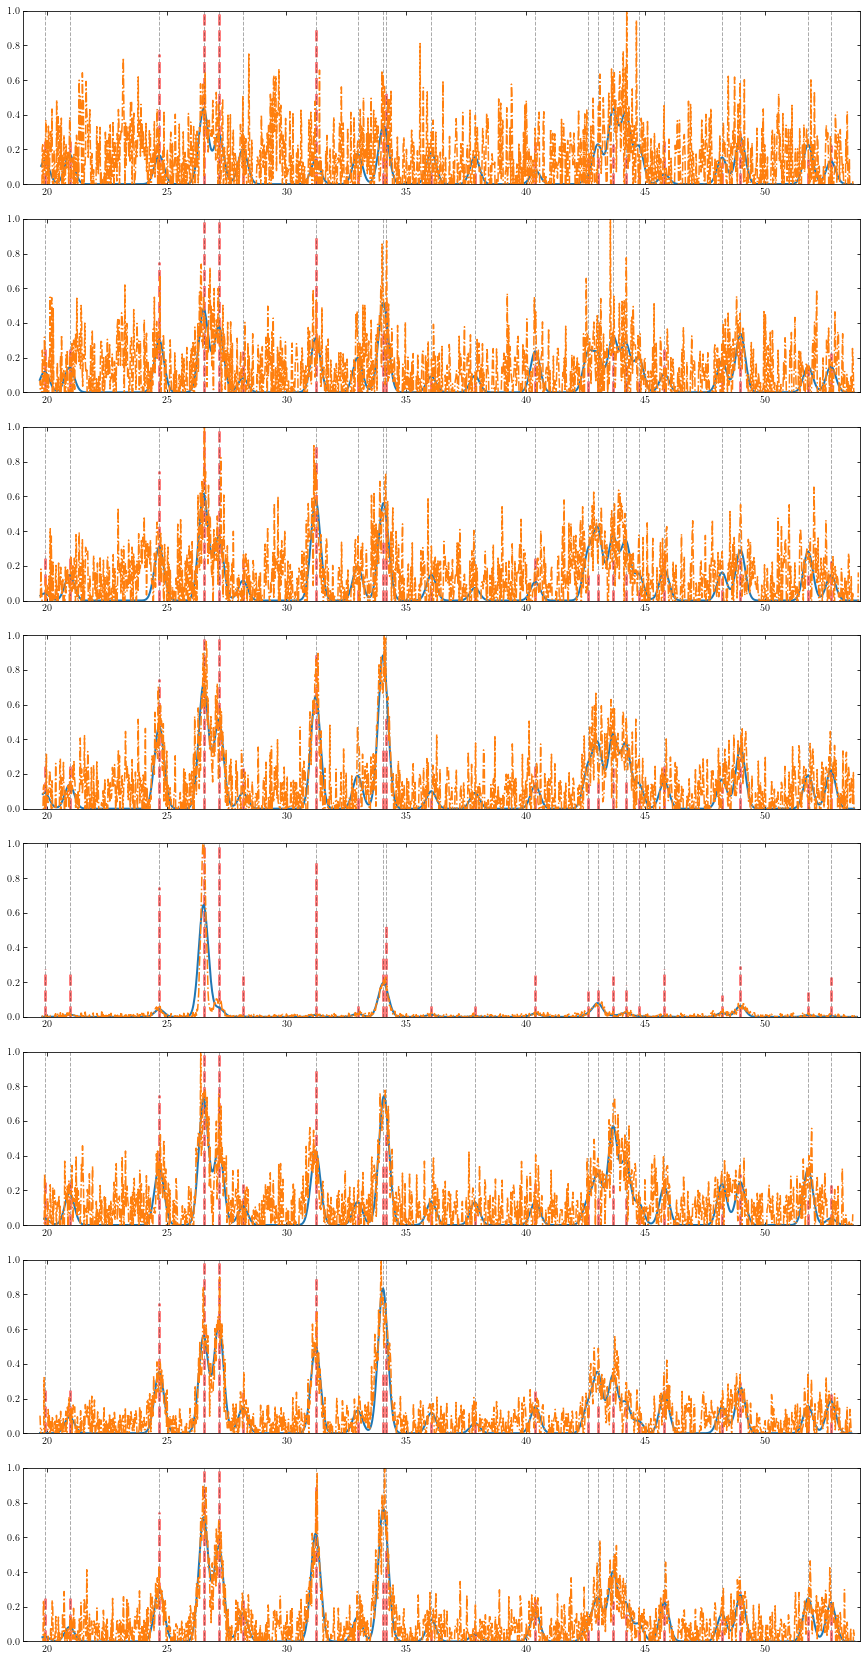

In [9]:
%matplotlib inline
fig,ax = subplots(len(xrd_gauss_newton),1,figsize = (15,30))

for i,g in enumerate(xrd_gauss_newton):
    
    g.spectra.opt = g.opt.copy()
    s = g.spectra
    
    ax[i].vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
    ax[i].plot(g.theta,g.z,'-',lw=2)
    ax[i].plot(s.theta,s.intensity,'-.')
    ax[i].vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)
    
    ax[i].vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

In [10]:
%%time

data = xrd_data.inverted.reshape(-1,1280)
profilo_gauss_newton = []

for d in data[:]:
    spectra = Spectra()
    spectra.from_array(d)
    spectra.opt[:] = array([-1185.2366578999117, 50.99999999999997, 1955.6511408474753])
    spectra.convolve(4).raw_snip(m=32)
    
    g = GaussNewton(phase,spectra)
    
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()
    for _ in range(2):
        g.calibration_nobeta(alpha=0.5)
        g.opt = g.spectra.opt.copy()

    #print(g.spectra.opt)
    
    profilo_gauss_newton += [g]
    

CPU times: user 10min 57s, sys: 177 ms, total: 10min 57s
Wall time: 10min 57s


In [14]:
t = []
for g in profilo_gauss_newton[:]:
    c = g.spectra.raw_intensity
    d = uniform_filter1d(c,64)
    t += [(c - d).std()]
t = array(t).reshape(95,170)
t.max(),t.min()

(79.3745372118337, 2.8907141033564265)

In [ ]:
%%time
for g in profilo_gauss_newton:
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()

In [15]:
out = array([g.dz for g in profilo_gauss_newton])
out = out.reshape(95,170)

In [16]:
out = array([g.dz for g in profilo_gauss_newton])
out = out.reshape(95,170)
save('Cinabar_Hydricerussite.npy',out)

a = array([g.opt[0] for g in profilo_gauss_newton])
a = a.reshape(95,170)
a.max(),a.argmin()
save('Cinabar_Hydricerussite_a.npy',a)

In [17]:
out.shape,xrd_data.inverted.shape

((95, 170), (95, 170, 1280))

In [18]:
out.max(),out.min()
save('cinabar_hydrocerussite.npy',out)

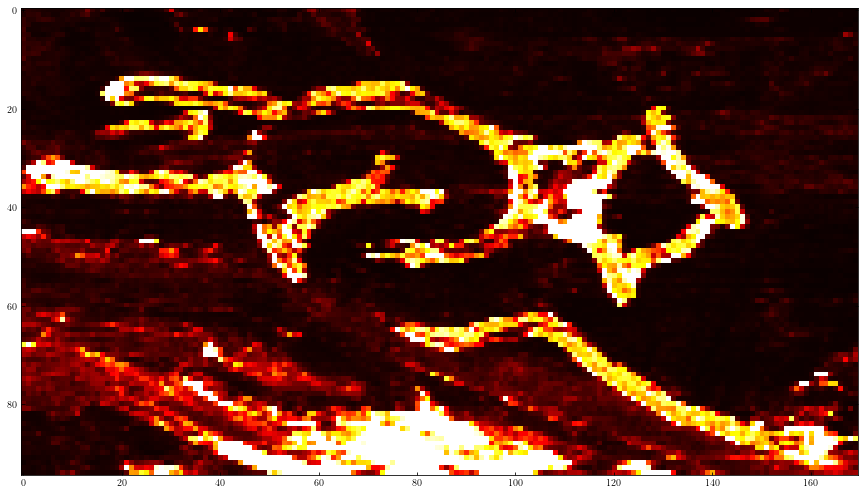

In [35]:
figure(figsize=(15,15))
imshow((out/t**1)[::-1],cmap='hot',vmax=1)
savefig('Lazurite_loss.png')

0.1776180539398249


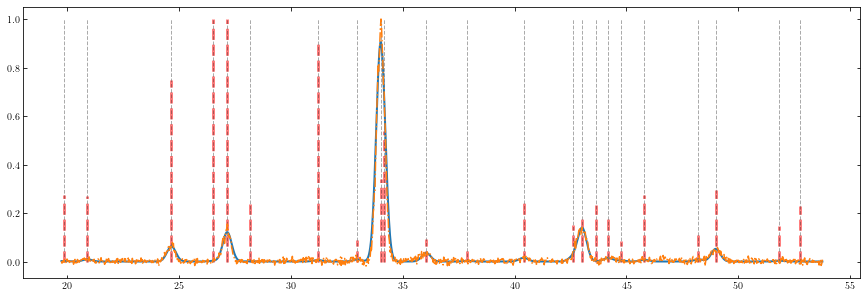

In [16]:
figure(figsize=(15,5))
g = profilo_gauss_newton[out.argmin()]
s =g.spectra

for _ in range(64):
    g.calibration_nobeta()
print(g.dz)
    
vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
plot(g.theta,g.z,'-',lw=2)
plot(s.theta,s.intensity,'-.')
vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)

vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)

In [ ]:
a = array([g.opt[0] for g in profilo_gauss_newton])
a = a.reshape(95,170)
a.max(),a.argmin()

In [ ]:
%matplotlib inline
figure(figsize=(15,15))
imshow(a[::-1])

In [ ]:
imshow(xrd_data.inverted[:,:,185],vmin=50)